In [1]:
import numpy as np 
import pandas as pd 

import sys
sys.path.append("/scratch/m/murray/dtolgay")

from get_spaxels import find_indices_inside_boxes

from tools import functions_readfiles as readfiles
from tools import constants
from tools import functions_importing_observations as observations

import h5py

import matplotlib
import matplotlib.pyplot as plt

In [2]:
def read_gas_particles_from_hdf5(file_path: str) -> pd.DataFrame:
    
    with h5py.File(file_path, 'r') as f:
        part_group = f['PartType0']

        # Load vector quantities
        p = part_group['p'][:]   # shape (N, 3)
        v = part_group['v'][:]

        # Load scalar quantities
        m = part_group['m'][:]
        rho = part_group['rho'][:]
        h = part_group['h'][:]
        sfr = part_group['sfr'][:]
        u = part_group['u'][:]
        T = part_group['T'][:]
        hden = part_group['hden'][:]
        isrf = part_group['isrf_skirt'][:] 
        z = part_group['z'][:]          # shape (N, 11)

    # Build dataframe
    df = pd.DataFrame({
        'x': p[:, 0],
        'y': p[:, 1],
        'z': p[:, 2],
        'vx': v[:, 0],
        'vy': v[:, 1],
        'vz': v[:, 2],
        'mass': m,
        'density': rho,
        'smoothing_length': h,
        'star_formation_rate': sfr,
        'internal_energy': u,
        'temperature': T,
        'hden': hden,
        'isrf': isrf,
        'metallicity': z[:, 0],
        'He_mass_fraction': z[:, 1],
        'C_mass_fraction': z[:, 2],
        'N_mass_fraction': z[:, 3],
        'O_mass_fraction': z[:, 4],
        'Ne_mass_fraction': z[:, 5],
        'Mg_mass_fraction': z[:, 6],
        'Si_mass_fraction': z[:, 7],
        'S_mass_fraction': z[:, 8],
        'Ca_mass_fraction': z[:, 9],
        'Fe_mass_fraction': z[:, 10],
    })

    return df


def combine_chimes_hdf5_files(path_to_chimes_file: str, gas_particles_before_chimes: pd.DataFrame) -> pd.DataFrame:

    with h5py.File(path_to_chimes_file, 'r') as f:
        after_chimes = f['EqmChemistryAbundances'][:]  # Load the dataset into a NumPy array

    chimes = gas_particles_before_chimes.copy()

    nco_over_nh = after_chimes[:, 148]  # Get all rows of column 148
    nh2_over_nh = after_chimes[:, 137]  # Get all rows of column 137

    # Calculate the mass fraction of H2 and CO
    chimes['fCO'] = nco_over_nh * constants.mco_molecular_mass 
    chimes['fH2'] = nh2_over_nh * constants.mh2_molecular_mass

    # Determine the volume of each particle
    chimes['volume'] = chimes['mass'] / (chimes['density'] * constants.gr2M_sun) # cm3

    # Calculate the number density of H2 and CO
    chimes['density_h2'] = chimes['density'] / constants.mu_h  * chimes['fH2'] # gr/cm3
    chimes['density_co'] = chimes['density'] / constants.mu_h  * chimes['fCO'] # gr/cm3

    # Calculate the mass of H2 and CO 
    chimes['mass_h2'] = chimes['density_h2'] * chimes['volume'] # gr
    chimes['mass_co'] = chimes['density_co'] * chimes['volume'] # gr

    return chimes 

# Reading CLOUDY data

In [3]:
# Read the cloudy particles 

base_dir = "/scratch/m/murray/dtolgay/post_processing_fire_outputs/skirt/runs_hden_radius"

galaxy_name = "gal0"
galaxy_type = "firebox"

# galaxy_name = "m12i_res7100_md"
# galaxy_type = "zoom_in"

directory_name = "voronoi_1e6"
# directory_name = "seperated_firebox_galaxies"
# directory_name = "voronoi_1e5"

file_name = "abundance_RBFInterpolator_smoothingLength.txt"
redshift = "0.0"

fdir = f'{base_dir}/{galaxy_type}/z{redshift}/{galaxy_name}/{directory_name}/{file_name}'

cloudy, file_specific_columns = readfiles.read_interpolated_files_usingFilePath(path = fdir, interpolation_type="abundance")

# Calculate mass densities
cloudy['density_h2'] = cloudy['density'] / constants.mu_h  * cloudy['fh2'] # gr/cm3
cloudy['density_co'] = cloudy['density'] / constants.mu_h  * cloudy['fCO'] # gr/cm3

# calcuulate the mass 
cloudy['volume'] = cloudy['mass'] / (cloudy['density'] * constants.gr2M_sun) # cm3
cloudy['mass_h2'] = cloudy['density_h2'] * cloudy['volume'] # gr
cloudy['mass_co'] = cloudy['density_co'] * cloudy['volume'] # gr


# Use only the cloudy particles within certain condition 
conditions = {
    "5kpc+disk":{
        "z_max": 500, # pc
        "Rgal": 5e3,  # pc
    }
}

cloudy["Rgal"] = np.sqrt(cloudy["x"]**2 + cloudy["y"]**2)
condition = (cloudy["Rgal"] < conditions["5kpc+disk"]["Rgal"]) & (abs(cloudy["z"]) < conditions["5kpc+disk"]["z_max"]) 
cloudy = cloudy[condition].copy().reset_index(drop=True)

# Reading CHIMES DATA

In [4]:
base_fdir = "/scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/hdf5_files"

# Read the hdf5 file 
hdf5_file_path = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/{galaxy_name}.hdf5"
print(f"Before chimes file path: {hdf5_file_path}")
before_chimes = read_gas_particles_from_hdf5(file_path = hdf5_file_path)

path_to_chimes_file = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/gal0_chimes_B87x1.hdf5"
chimes_B87x1 = combine_chimes_hdf5_files(path_to_chimes_file=path_to_chimes_file, gas_particles_before_chimes=before_chimes.copy())

path_to_chimes_file = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/gal0_chimes_B87x0.1.hdf5"
chimes_B87x01 = combine_chimes_hdf5_files(path_to_chimes_file=path_to_chimes_file, gas_particles_before_chimes=before_chimes.copy())

path_to_chimes_file = f"{base_fdir}/{galaxy_type}/z{redshift}/{galaxy_name}/gal0_chimes_B87x0.5.hdf5"
chimes_B87x05 = combine_chimes_hdf5_files(path_to_chimes_file=path_to_chimes_file, gas_particles_before_chimes=before_chimes.copy())

Before chimes file path: /scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/hdf5_files/firebox/z0.0/gal0/gal0.hdf5


# Main

In [5]:
def calculate_spaxels(gas:pd.DataFrame, conditions:dict, resolution=1e3) -> pd.DataFrame:

    """
    resolution: pc
    """

    # Calculate the spaxel coordinates
    indices, lower_left_corner_coordinates, upper_right_corner_coordinates, box_coordinates = find_indices_inside_boxes(
        max_length = conditions["5kpc+disk"]["Rgal"], 
        resolution = resolution, 
        particles_df = gas, 
        overlap_shift=0
    )


    values_for_all_spaxels = []

    for indices_in_cell, lower_left_corner_coordinate in zip(indices, lower_left_corner_coordinates):
        
        # Initiate a dictionary to store the calculated values 
        calculated_properties = {} # Fresh start in each iteration.
        
        # Calculate the center coordinates of the spaxel
        x_center = lower_left_corner_coordinate[0] + resolution/2   # pc
        y_center = lower_left_corner_coordinate[1] + resolution/2   # pc     
        distance = np.sqrt(x_center**2 + y_center**2)               # pc 
        
        
        calculated_properties.update({
            "x_center": {
                "unit": "pc",
                "value": x_center,
                "column_name": "x_center",
            },
            "y_center": {
                "unit": "pc",
                "value": y_center,
                "column_name": "y_center",
            },
            "distance": {
                "unit": "pc",
                "value": distance,
                "column_name": "distance",
            },                        
        })    
        
        
        # Filter the particles 
        filtered_gas = gas.iloc[indices_in_cell].copy()
        
        # Calculate the total mass 
        total_co_mass = sum(filtered_gas["mass_co"])
        total_h2_mass = sum(filtered_gas["mass_h2"])
        
        # Calculate the surface number density 
        Nco = total_co_mass / (resolution * constants.pc2cm)**2 / constants.mco_gr # cm-2
        Nh2 = total_h2_mass / (resolution * constants.pc2cm)**2 / constants.mh2_gr # cm-2
        
        calculated_properties.update({
            "Nco": {
                "unit": "cm-2",
                "value": Nco,
                "column_name": "Nco",
            },
            "Nh2": {
                "unit": "cm-2",
                "value": Nh2,
                "column_name": "Nh2",
            },
        })
        
        
        # I calculated the spaxel properties. Now I will add it into the dataframe
        # Start a new arrays in after each spaxel.        
        values_for_this_run = []     
        column_names = [] 
        units = []   
        for key in list(calculated_properties.keys()):
            values_for_this_run.append(calculated_properties[key]["value"])
            column_names.append(f'{calculated_properties[key]["column_name"]}')
            units.append(f'{calculated_properties[key]["unit"]}')

        values_for_all_spaxels.append(values_for_this_run)



    ##### Outside of the loop 
    values_for_all_spaxels = np.array(values_for_all_spaxels)
    data_df = pd.DataFrame(values_for_all_spaxels, columns=column_names)        

    return data_df



In [67]:
resolution = 1e2
spaxels_cloudy = calculate_spaxels(gas=cloudy, conditions=conditions, resolution=resolution)
spaxels_chimes_B87x1 = calculate_spaxels(gas=chimes_B87x1, conditions=conditions, resolution=resolution)
spaxels_chimes_B87x01 = calculate_spaxels(gas=chimes_B87x01, conditions=conditions, resolution=resolution)
# spaxels_chimes_B87x05 = calculate_spaxels(gas=chimes_B87x05, conditions=conditions, resolution=resolution)

1 finished. Left 9999
1001 finished. Left 8999
2001 finished. Left 7999
3001 finished. Left 6999
4001 finished. Left 5999
5001 finished. Left 4999
6001 finished. Left 3999
7001 finished. Left 2999
8001 finished. Left 1999
9001 finished. Left 999
Number of boxes: 10000
Done!
1 finished. Left 9999
1001 finished. Left 8999
2001 finished. Left 7999
3001 finished. Left 6999
4001 finished. Left 5999
5001 finished. Left 4999
6001 finished. Left 3999
7001 finished. Left 2999
8001 finished. Left 1999
9001 finished. Left 999
Number of boxes: 10000
Done!
1 finished. Left 9999
1001 finished. Left 8999
2001 finished. Left 7999
3001 finished. Left 6999
4001 finished. Left 5999
5001 finished. Left 4999
6001 finished. Left 3999
7001 finished. Left 2999
8001 finished. Left 1999
9001 finished. Left 999
Number of boxes: 10000
Done!


In [7]:
# #################################### Plot
# R_max = 20e3 # pc

# print("Plotting galaxy")
# # Create a figure with two subplots
# fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# # First subplot: x-y axis plot
# axs[0].hist2d(
#     x=gas["x"],
#     y=gas["y"],
#     bins=500,
#     norm=matplotlib.colors.LogNorm(),
#     range=[[-R_max, R_max], [-R_max, R_max]]
# )
# axs[0].set_title('x-y axis plot')
# axs[0].set_xlabel('x')
# axs[0].set_ylabel('y')

# # Second subplot: z-y axis plot
# axs[1].hist2d(
#     x=gas["y"],  # Use the 'y' column for the x-axis
#     y=gas["z"],  # Keep the 'z' column for the y-axis
#     bins=500,
#     norm=matplotlib.colors.LogNorm(),
#     range=[[-R_max, R_max], [-R_max, R_max]]
# )
# axs[1].set_title('z-y axis plot')
# axs[1].set_xlabel('y')
# axs[1].set_ylabel('z')

# # Show the figure
# plt.tight_layout()

# Import observations

In [8]:
rachford = observations.rachford_2002_number_column_density(filedir = "/home/m/murray/dtolgay/Observations")

/gpfs/fs0/scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


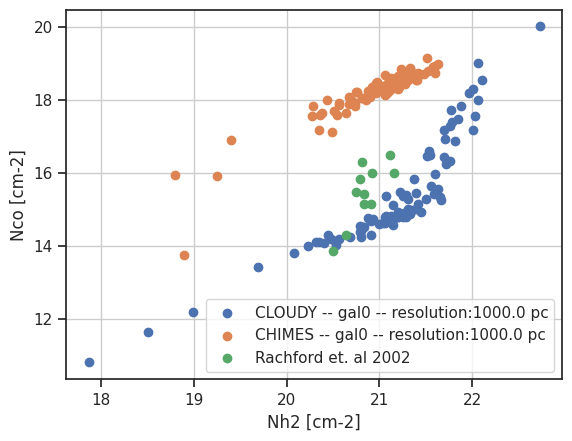

In [14]:
plt.scatter(
    np.log10(spaxels_cloudy["Nh2"]),
    np.log10(spaxels_cloudy["Nco"]),
    label = f"CLOUDY -- {galaxy_name} -- resolution:{resolution} pc"
)
plt.scatter(
    np.log10(spaxels_chimes_B87x1["Nh2"]),
    np.log10(spaxels_chimes_B87x1["Nco"]),
    label = f"CHIMES -- {galaxy_name} -- resolution:{resolution} pc"
)
plt.scatter(
    rachford["logN(H2)"],
    rachford["log(N(CO))"],
    label = "Rachford et. al 2002"
)
plt.legend()
plt.grid(True)
plt.ylabel("Nco [cm-2]")
plt.xlabel("Nh2 [cm-2]")
plt.show()

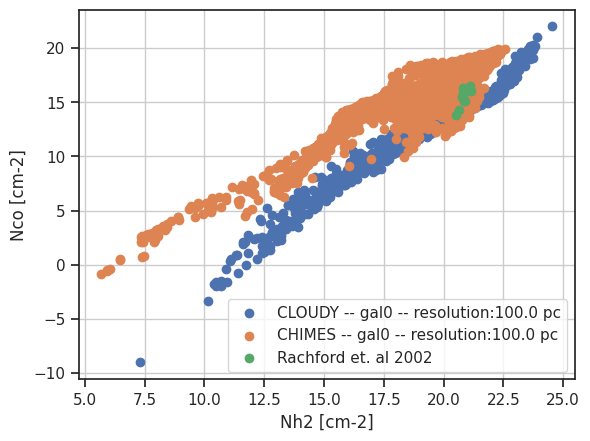

In [16]:
plt.scatter(
    np.log10(spaxels_cloudy["Nh2"]),
    np.log10(spaxels_cloudy["Nco"]),
    label = f"CLOUDY -- {galaxy_name} -- resolution:{resolution} pc"
)
plt.scatter(
    np.log10(spaxels_chimes_B87x1["Nh2"]),
    np.log10(spaxels_chimes_B87x1["Nco"]),
    label = f"CHIMES -- {galaxy_name} -- resolution:{resolution} pc"
)
plt.scatter(
    rachford["logN(H2)"],
    rachford["log(N(CO))"],
    label = "Rachford et. al 2002"
)
plt.legend()
plt.grid(True)
plt.ylabel("Nco [cm-2]")
plt.xlabel("Nh2 [cm-2]")
plt.show()

In [61]:
def bin_data(spaxel_data):

    binned_data = []

    bins_Nh2 = np.linspace(start=5, stop=25, num=100)


    # Create mask for the data 
    for i in range(len(bins_Nh2)-1):
        mask = (np.log10(spaxel_data["Nh2"]) > bins_Nh2[i]) & (np.log10(spaxel_data["Nh2"]) < bins_Nh2[i+1])
        # Calculate the mean of Nco for the current bin
        mean_Nco = np.mean(spaxel_data["Nco"][mask])
        # Calculate the mean of Nh2 for the current bin
        mean_Nh2 = np.mean(spaxel_data["Nh2"][mask])

        # Calculate the standard deviation of Nco for the current bin
        std_Nco = np.std(spaxel_data["Nco"][mask])

        binned_data.append({
            "Nh2": mean_Nh2,
            "Nco": mean_Nco,
            "std_Nco": std_Nco
        })


    binned_data = pd.DataFrame(binned_data)

    return binned_data

/gpfs/fs0/scratch/m/murray/dtolgay/post_processing_fire_outputs/chimes/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


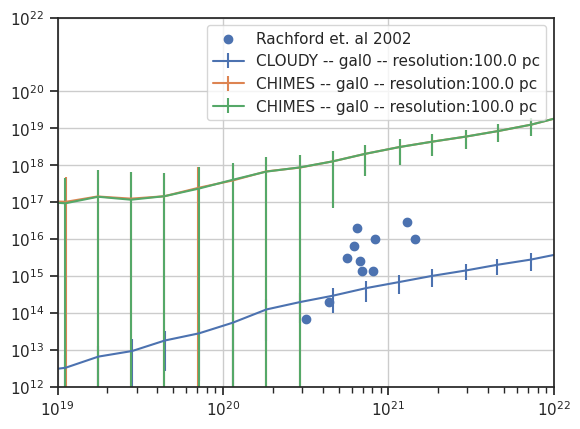

In [71]:
binned_cloudy = bin_data(spaxel_data=spaxels_cloudy)
binned_chimes_B87x1 = bin_data(spaxel_data=spaxels_chimes_B87x1)
binned_chimes_B87x01 = bin_data(spaxel_data=spaxels_chimes_B87x01)

# Plot these binned data
plt.errorbar(
    binned_cloudy["Nh2"],
    binned_cloudy["Nco"],
    yerr=binned_cloudy["std_Nco"],
    label = f"CLOUDY -- {galaxy_name} -- resolution:{resolution} pc"
)
plt.errorbar(
    binned_chimes_B87x1["Nh2"],
    binned_chimes_B87x1["Nco"],
    yerr=binned_chimes_B87x1["std_Nco"],
    label = f"CHIMES -- {galaxy_name} -- resolution:{resolution} pc"
)    
plt.errorbar(
    binned_chimes_B87x01["Nh2"],
    binned_chimes_B87x01["Nco"],
    yerr=binned_chimes_B87x01["std_Nco"],
    label = f"CHIMES -- {galaxy_name} -- resolution:{resolution} pc"
)
plt.scatter(
    10**rachford["logN(H2)"],
    10**rachford["log(N(CO))"],
    label = "Rachford et. al 2002"
)

plt.xscale("log")
plt.yscale("log")
plt.xlim([1e19, 1e22])
plt.ylim([1e12, 1e22])
plt.grid(True)
plt.yticks([1e12, 1e13, 1e14, 1e15, 1e16, 1e17, 1e18, 1e19, 1e20, 1e22])
plt.legend()